# コンクリートのひび割れを Mask R-CNNで探す

構造工学でのAI活用に関する研究小委員会：後藤 良輔 (Search Space株式会社)，全　邦釘（東京大学）



*本編はPytorch公式サイトで紹介されている、[こちらのチュートリアル](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)をコンクリート構造物のひび割れを探す形に翻訳・加筆したものです*

*This notebook is based on ["TorchVision Object Detection Finetuning Tutorial"](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) that is pulished on pytorch.org. The author translated and arranged the original article adding his own code to it.*


## はじめに


このチュートリアルでは、DeepCrackデータセットを使って、学習済みの [Mask R-CNN](https://arxiv.org/abs/1703.06870) モデルを転移学習・ファインチューニングします。

Mask R-CNNは物体検出・領域分割を行う深層学習モデルであり、DeepCrackデータセットはおよそ700件のコンクリート画像とそのひび割れに対応した二値マスクを含んでいます。これらを使ってコンクリート構造物のひび割れを探すというタスクの自動化を試みます。

まずはじめに、`pycocotools` をインストールします。モデルの性能評価には、ひび割れとして予測された領域と正解領域の重なりを指標として使いますが、こちらはそれを一般的なCOCO形式に準拠した形で測定するために必要なツールとなります。

In [ ]:
%%shell
pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sqp81w7r
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sqp81w7r
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264280 sha256=b2bdb00f71faf9f4da4ead37e62e8c2c590cb4cf47f4467163ac73cf5dbb1de7
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnu68ya6/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


## データセット

PyTorchにはtorchvisionと呼ばれるサブモジュールがあり、そちらには物体検出・領域抽出・特徴点（キーポイント）検出の参考実装が含まれています。それらを活用することで、独自のデータセットを比較的容易に活用することが可能です。

データセットは `torch.utils.data.Dataset` クラスを継承し、`__len__` と `__getitem__` のメソッドを実装する必要がありますが、今回のMask R-CNNの実装では、データセットの `__getitem__` が以下を戻り値として返すことも必要です。

* image: (H, W) で定義されるサイズの PIL 画像
* target: 以下のフィールドを含む辞書
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` 個の矩形領域(bounding box) を `x` が`0` から `W`、`y` が `0` から `H` の範囲の `[x0, y0, x1, y1]` 形式の座標で表現したもの
    * `labels` (`Int64Tensor[N]`): 各々の矩形領域のラベル
    * `image_id` (`Int64Tensor[1]`): 画像識別子で、性能評価にも使われるためデータセットを通じて一意である必要がある
    * `area` (`Tensor[N]`): 矩形領域の面積 - COCO準拠の指標で、大・中・小それぞれの矩形に対して性能を図るために必要となる
    * `iscrowd` (`UInt8Tensor[N]`): もし `iscrowd=True` となっていた場合は、性能評価時に無視される
    * (任意) `masks` (`UInt8Tensor[N, H, W]`): それぞれの検出対象に対する領域分割（セグメンテーション）マスク
    * (任意) `keypoints` (`FloatTensor[N, K, 3]`): それぞれ `N` 個のそれぞれの検出対象につき `K` 個の特徴点（キーポイント）を `[x, y, visibility]` の形式で定義する - `visibility=0` は特徴点が見えないことを意味する (データ増強（オーギュメンテーション）時には、特徴点の反転はデータの表現形式に依存するため、 `references/detection/transforms.py` などを合わせて修正する必要がある)
 
もし作成したモデルが上記を戻り値として返せるなら、トレーニングにも推論にも、pycocotoolsでの評価にも問題なく使えることになります。

※ 今回は縦横比を使う実装は省略しますが、もし縦横比をトレーニングに使いたい場合（バッチごとに含まれる画像を似たような縦横比にしたい、など）は、縦と横のサイズを返す `get_height_and_width` メソッドを実装します。縦横比を指定する場合、そのメソッドがないと画像全体を対象として探す必要があるために実行効率が落ちてしまいます。


### コンクリートひび割れデータのためにカスタムクラスを準備する

DeepCrackデータセットのために、カスタムのデータセットクラスを記述してみましょう。まずはじめに、データセットをGithubからダウンロードします。

※ 当該データセットは非商用・教育目的の利用に限って使用を許可されていますのでご注意ください。

In [ ]:
%%shell
# DeepCrack データセットをダウンロードする
mkdir ./DeepCrack
wget https://github.com/yhlleo/DeepCrack/raw/master/dataset/DeepCrack.zip

# "DeepCrack" フォルダに解凍する
unzip -q DeepCrack.zip -d ./DeepCrack

--2021-02-26 01:04:20--  https://github.com/yhlleo/DeepCrack/raw/master/dataset/DeepCrack.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yhlleo/DeepCrack/master/dataset/DeepCrack.zip [following]
--2021-02-26 01:04:20--  https://raw.githubusercontent.com/yhlleo/DeepCrack/master/dataset/DeepCrack.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67708808 (65M) [application/zip]
Saving to: ‘DeepCrack.zip’

DeepCrack.zip       100%[===================>]  64.57M   301MB/s    in 0.2s    

2021-02-26 01:04:21 (301 MB/s) - ‘DeepCrack.zip’ saved [67708808/67708808]



データセットの中身を見てみましょう。

データは以下のようなフォルダ構成になっていると思います。

```
DeepCrack/
  train_img/
    11111.jpg
    11112.jpg
    11113.jpg
    11114.jpg
    ...
  train_lab/
    11111.png
    11112.png
    11113.png
    11114.png
```

どんな画像が入っているのか、一つ見てみることにします。

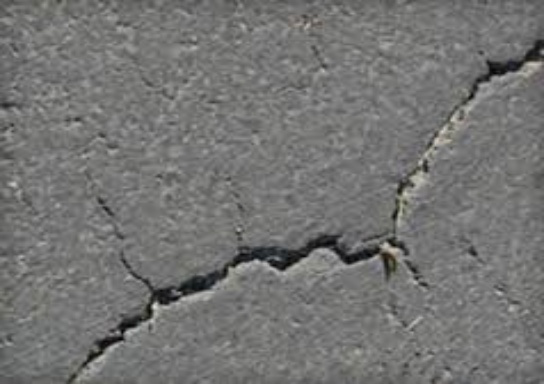

In [ ]:
from PIL import Image
Image.open('DeepCrack/train_img/11115.jpg')

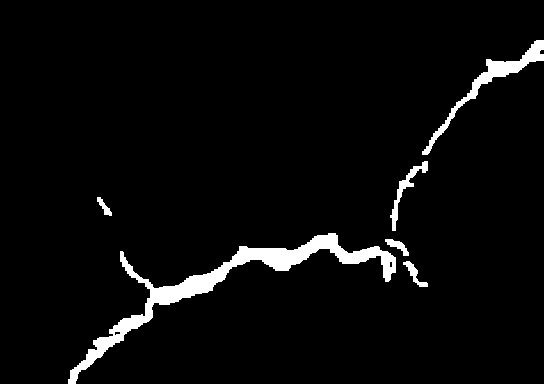

In [ ]:
Image.open('DeepCrack/train_lab/11115.png')

一つ一つの画像にひび割れに対応するマスクが存在していることがわかります。

`torch.utils.data.Dataset` に沿った形でデータセットのクラスを記述してみます。

In [ ]:
import os
import torch
import numpy as np
from numpy.lib.function_base import delete
from PIL import Image
from PIL.Image import Image as Pilimg
from typing import Tuple


class ConcreteCrackDataset(object):
    def __init__(self, root:str, transforms=None):
        self.transforms = transforms
        
        # 全ての画像を読み込み、すべてそろっていることを確認するためにソートする
        self.img_dir = os.path.join(root, "train_img")
        self.mask_dir = os.path.join(root, "train_lab") 

        self.masks = list(sorted(os.listdir(self.mask_dir)))  
        self.imgs = list(sorted(os.listdir(self.img_dir)))

    def __getitem__(self, idx:int) -> Tuple[Pilimg, dict]:
        # 画像とマスクを読み込む
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # 複数クラスがある場合の対応
        obj_ids = np.unique(mask)
        # 最初のクラスIDは背景なので削除する
        obj_ids = obj_ids[1:]

        # 色で分けられたマスクの場合は、二値化する
        masks = mask == obj_ids[:, None, None]

        # マスクごとの矩形領域を計算する
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor([b for b in boxes if self._valid_bbox(b)], dtype=torch.float32)
        # 検出対象のクラスは一つ（ひび割れ）だけ
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        except:
            print("You need to remove this sample: ", img_path, boxes)
            area = None
        # 全部のクラスが iscrowd ではない形にする
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def _valid_bbox(self, box):
        return box[0] < box[2] and box[1] < box[3]

    def __len__(self):
        return len(self.imgs)

データセットの定義は以上です。出力されるデータがどんな構造になっているか、確認してみましょう。

In [ ]:
dataset = ConcreteCrackDataset('DeepCrack')
dataset[0]

(<PIL.Image.Image image mode=RGB size=544x384 at 0x7FB4B9B88210>,
 {'area': tensor([61359.]),
  'boxes': tensor([[  0., 112., 543., 225.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

データセットのクラスは `PIL.Image` と、 `boxes`, `labels` や `masks` といった様々なフィールドを含む辞書を戻り値として返していることがわかります。

## モデルを定義する

本編で扱う [Mask R-CNN](https://arxiv.org/abs/1703.06870) は [Faster R-CNN](https://arxiv.org/abs/1506.01497) を基にしています。Faster R-CNN は画像内に矩形領域を探し、その領域が囲む検出対象が何かを予測します。

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNNは論理的な分岐をFaster R-CNNに追加することで、それぞれの対象に対して領域分割マスクも同時に予測するという特徴があります。

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)


Torchvisionのmodelzooには様々なプリセットのモデルが含まれていますが、これを改変して使う目的としては、大きく二つ考えられます。

一つはすでに学習済みのモデルの最終層をファインチューニングするという用途ですが、それ以外にも、モデルのバックボーンを別のものに取り換えて使うという用途にも活用可能です。

少し詳しく見ていきます。


### 1 - 学習済みモデルをファインチューニングする

COCOデータセットで学習済みのモデルの最終層だけを取り換え、自分のデータセットで転移学習させたい状況であれば、以下の形が考えられます。

```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCOデータセットで学習済みのモデルをロードする
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 分類器（最終の全結合層）を新しいものに取り換え
# num_classes を自分のデータセットのクラス数に変更する
num_classes = 2  # 1 class (ひび割れ) + 背景

# 分類器への入力の次元数を取得する
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 学習済みのモデルのヘッドを新しいものに取り換える
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - 別のバックボーンを追加して物体検出モデルを改変する

さらにもう一つ、一般的なケースとして物体検出モデルのバックボーンを取り換えたいという状況が考えられます。例えば、現状のバックボー(ResNet-50)が大きすぎ、もっと小さいモデルに付け替えたいという場合などがあり得ます。

以下は、torchvisionにもともとある機能を活用してバックボーンを変更するやり方です。

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 学習済みの画像分類モデルを呼び出し、特徴抽出部分だけを
# 取り出す
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN にバックボーンの出力次元数を伝える必要がある
# mobilenet_v2 の場合、1280次元なのでそれを記述する
backbone.out_channels = 1280

# 画面上の位置ごとに5 x 3のアンカーを生成するRPN（領域提案ネットワーク）
# を5つの違うサイズ、3つの違う縦横比で作成する。
# Tuple[Tuple[int]] にしているのは、それぞれの特徴マップが別のサイズ、
# 別の縦横比になってしまう可能性があるため
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


# 重複領域の切り取り、リサイズ後の切り取りを次項する特徴マップを
# 定義します。
# もし上記で定義したバックボーンが Tensor を戻り値として返す場合、
# featmap_names は [0] でなければいけません。一般的にバックボーンの
# 戻り値は単一の OrderedDict[Tensor] であり、 featmap_names で
# どの特徴マップを使うかを指定することができます。
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# 全てを一つの FasterRCNN モデルにまとめます
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### DeepCrackデータセットを使ったインスタンス・セグメンテーション（領域抽出）

今回はデータセットが小さいため、上の例の1番に沿った形で学習済みのモデルをファインチューニングします。

また、領域を抽出したいため、Faster R-CNNではなくMask R-CNNを使います。


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # COCOで学習済みのインスタンス・セグメンテーションモデルを読み込む
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # 分類器の特徴量の次元数を取得する
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 学習済みのモデルのヘッドを新しいものに取り換える
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # マスク用の分類器への入力となる、特徴量の次元数を取得する
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # マスク推論部分を新しいものと入れ替える
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

以上で、用意したカスタムデータセットを使う、モデルのトレーニングと評価の準備が整いました。

## モデルトレーニングと評価関数

Torchvisionの `references/detection/` には、物体検出モデルのトレーニングと性能評価をより容易にする機能が色々と含まれています。
今回は、 `references/detection/engine.py`、 `references/detection/utils.py` と `references/detection/transforms.py` を使用します。

まず、そういったファイルと必要なライブラリを使えるようコピーしていきます。

In [ ]:
%%shell

# TorchVision の references/detection を使うため
# 一部のファイルをコピーする
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 16390 (delta 0), reused 4 (delta 0), pack-reused 16386
Receiving objects: 100% (16390/16390), 16.00 MiB | 23.78 MiB/s, done.
Resolving deltas: 100% (11765/11765), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


その次に、コピーした `reference/detection` を基に、データ増強（オーギュメンテーション）やデータ変換の補助関数を書いてみましょう。


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # PIL image の画像を PyTorch Tensor に変換する
    transforms.append(T.ToTensor())
    if train:
        # トレーニング時にデータ増強を行うため、ランダムに入力画像と
        # 正解を反転させる
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

尚、画像に対してのリサイズ、ピクセル値の平均・標準偏差を使った正規化はMask R-CNNモデル内部で行われるため、こちらで記述する必要はありません。

### 実際に動かしてみる 

データセットクラス、モデルとデータ変換がそろいましたので、早速それらをインスタンス化してみましょう。

In [ ]:
# 定義されたデータ変換とカスタムデータセットを使う
dataset = ConcreteCrackDataset('DeepCrack', get_transform(train=True))
dataset_test = ConcreteCrackDataset('DeepCrack', get_transform(train=False))

# トレーニングとテスト用にデータセットを分割する
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# トレーニングと評価用のデータローダーを定義する
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

モデルとオプティマイザー（最適化）もインスタンス化します。

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 今回のデータセットでは2クラスのみ - 背景とコンクリートひび割れ
num_classes = 2

# 補助関数でモデルを取得する
model = get_instance_segmentation_model(num_classes)
# モデルをデバイスに移動・配置する
model.to(device)

# オプティマイザーを設定する
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# 学習係数のスケジューラーを用意し、3エポックごとに学習係数を
# 1/10に減らしていく
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


10エポックのトレーニングを開始し、各エポックの最後に性能を評価します。

In [ ]:
# 10 epoch学習させる
num_epochs = 10

for epoch in range(num_epochs):
    # 1エポックごとにトレーニングし、30バッチごとに状況をprintする
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=30)
    # 学習係数の更新
    lr_scheduler.step()
    # 性能評価を行う
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/125]  eta: 0:01:57  lr: 0.000045  loss: 0.3157 (0.3157)  loss_classifier: 0.0625 (0.0625)  loss_box_reg: 0.1173 (0.1173)  loss_mask: 0.1179 (0.1179)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 0.9421  data: 0.3177  max mem: 2527
Epoch: [0]  [ 50/125]  eta: 0:00:41  lr: 0.002059  loss: 0.2483 (0.2743)  loss_classifier: 0.0370 (0.0416)  loss_box_reg: 0.0675 (0.0721)  loss_mask: 0.1041 (0.1128)  loss_objectness: 0.0046 (0.0098)  loss_rpn_box_reg: 0.0369 (0.0380)  time: 0.5509  data: 0.0068  max mem: 2527
Epoch: [0]  [100/125]  eta: 0:00:13  lr: 0.004074  loss: 0.2805 (0.2751)  loss_classifier: 0.0363 (0.0387)  loss_box_reg: 0.0664 (0.0686)  loss_mask: 0.1154 (0.1113)  loss_objectness: 0.0036 (0.0087)  loss_rpn_box_reg: 0.0349 (0.0478)  time: 0.5635  data: 0.0067  max mem: 2527
Epoch: [0]  [124/125]  eta: 0:00:00  lr: 0.005000  loss: 0.2383 (0.2766)  loss_classifier: 0.0313 (0.0375)  loss_box_reg: 0.0647 (0.0670)  loss_mask: 0.0860 (0.1103) 

トレーニングが終わりました。テストデータセットの画像で問題なく推論ができているかを確認します。

In [ ]:
# テストセットから一つ画像を拾う
img, target = dataset_test[0]
# モデルを評価モードに設定し、入力として画像を与える
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

推論結果をprintしてみると、辞書の配列になっていることがわかります。リストの要素は、それぞれの画像に対応しています。今回、画像は一枚のみを使って推論していますので、配列の中の辞書は一つです。
辞書は渡した画像に対する推論結果を保持しています。今回のモデルでは、辞書が `boxes`、 `labels`、 `masks` 、 `scores` をフィールドとして持っていることがわかります。

In [ ]:
prediction

[{'boxes': tensor([[  0.0000,  48.0321, 544.0000, 209.5231],
          [ 17.4217,  93.8791, 532.6796, 176.5667],
          [  0.0000, 105.4339, 532.2299, 271.6255],
          [247.5090,  46.0865, 530.9727, 178.2255],
          [  0.0000,  76.9308, 357.4537, 197.9704]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  .

イメージの中身と推論結果の領域分割マスクも見てみます。

中身の確認のためには、0-1の値で表現されている画像のスケールを変更し、`[C, H, W]` の形式で表現されているチャネルを反転させる必要があります。

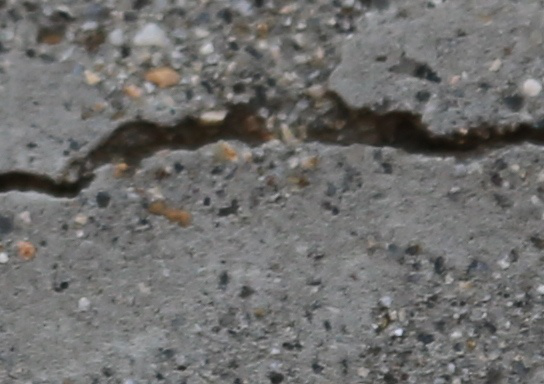

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

次に、推論結果の領域分割マスクを視覚化してみましょう。マスクは `[N, 1, H, W]` の形式で表現されており、`N` は推論結果の数を表しています。また確率も0-1の範囲で表現されています。

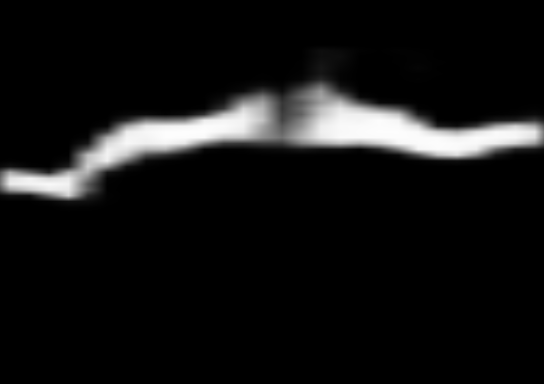

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

正解のマスクも確認します

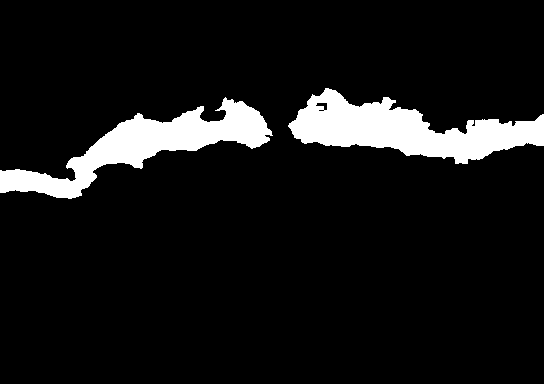

In [ ]:
Image.fromarray(target['masks'][0].mul(255).byte().cpu().numpy())

うまくいっているようです！


## まとめ

このチュートリアルでは、独自のデータセットを使って、トレーニングのパイプラインをセグメンテーションモデル向けに作成する方法をご紹介しました。

独自データセットを使うためには、`torch.utils.data.Dataset` クラスを記述し、画像と正解の矩形、領域分割マスクを戻り値として返す実装を行いました。また、今回は新しいデータセットで転移学習を行うために、COCO train2017で学習済みのMask R-CNNモデルを活用しました。

いかがだったでしょうか？

尚、より完成されており、複数マシン・複数GPUのトレーニングにも対応した `references/detection/train.py` が、[Torchvision](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) のGithubレポジトリにありますので、是非参考にされてみてください。